# Time series outlier detection with Seq2Seq models on synthetic data

## Method

The [Sequence-to-Sequence](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) (Seq2Seq) outlier detector consists of 2 main building blocks: an encoder and a decoder. The encoder consists of a [Bidirectional](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks) [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) which processes the input sequence and initializes the decoder. The LSTM decoder then makes sequential predictions for the output sequence. In our case, the decoder aims to reconstruct the input sequence. If the input data cannot be reconstructed well, the reconstruction error is high and the data can be flagged as an outlier. The reconstruction error is measured as the mean squared error (MSE) between the input and the reconstructed instance. 

Since even for normal data the reconstruction error can be state-dependent, we add an outlier threshold estimator network to the Seq2Seq model. This network takes in the hidden state of the decoder at each timestep and predicts the estimated reconstruction error for normal data. As a result, the outlier threshold is not static and becomes a function of the model state. This is similar to [Park et al. (2017)](https://arxiv.org/pdf/1711.00614.pdf), but while they train the threshold estimator separately from the Seq2Seq model with a Support-Vector Regressor, we train a neural net regression network end-to-end with the Seq2Seq model.

The detector is first trained on a batch of unlabeled, but normal (*inlier*) data. Unsupervised training is desireable since labeled data is often scarce. The Seq2Seq outlier detector is suitable for both **univariate and multivariate time series**.

## Dataset

We test the outlier detector on a synthetic dataset generated with the [TimeSynth](https://github.com/TimeSynth/TimeSynth) package. It allows you to generate a wide range of time series (e.g. pseudo-periodic, autoregressive or Gaussian Process generated signals) and noise types (white or red noise). It can be installed as follows:

```bash
!pip install git+https://github.com/TimeSynth/TimeSynth.git
```

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
import tensorflow as tf
import timesynth as ts

from alibi_detect.od import OutlierSeq2Seq
from alibi_detect.utils.perturbation import inject_outlier_ts
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_feature_outlier_ts

## Create multivariate time series

Define number of sampled points and the type of simulated time series. We use [TimeSynth](https://github.com/TimeSynth/TimeSynth) to generate sinusoidal signals with noise.

In [2]:
n_points = int(1e6)  # number of timesteps
perc_train = 80  # percentage of instances used for training
perc_threshold = 10  # percentage of instances used to determine threshold
n_train = int(n_points * perc_train * .01)
n_threshold = int(n_points * perc_threshold * .01)
n_features = 2  # number of features in the time series
seq_len = 50  # sequence length

In [3]:
# set random seed
np.random.seed(0)

# timestamps
time_sampler = ts.TimeSampler(stop_time=n_points // 4)
time_samples = time_sampler.sample_regular_time(num_points=n_points)

# create time series
ts1 = ts.TimeSeries(
    signal_generator=ts.signals.Sinusoidal(frequency=0.25),
    noise_generator=ts.noise.GaussianNoise(std=0.1)
)
samples1 = ts1.sample(time_samples)[0].reshape(-1, 1)

ts2 = ts.TimeSeries(
    signal_generator=ts.signals.Sinusoidal(frequency=0.15),
    noise_generator=ts.noise.RedNoise(std=.7, tau=0.5)
)
samples2 = ts2.sample(time_samples)[0].reshape(-1, 1)

# combine signals
X = np.concatenate([samples1, samples2], axis=1).astype(np.float32)

# split dataset into train, infer threshold and outlier detection sets
X_train = X[:n_train]
X_threshold = X[n_train:n_train+n_threshold]
X_outlier = X[n_train+n_threshold:]

# scale using the normal training data
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_threshold = (X_threshold - mu) / sigma
X_outlier = (X_outlier - mu) / sigma
print(X_train.shape, X_threshold.shape, X_outlier.shape)

(800000, 2) (100000, 2) (100000, 2)


Visualize:

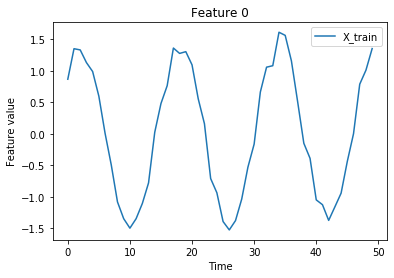

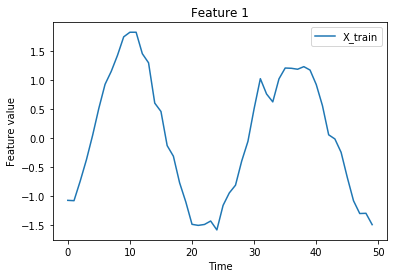

In [4]:
n_features = X.shape[-1]
istart, istop = 50, 100
for f in range(n_features):
    plt.plot(X_train[istart:istop, f], label='X_train')
    plt.title('Feature {}'.format(f))
    plt.xlabel('Time')
    plt.ylabel('Feature value')
    plt.legend()
    plt.show()

## Load or define Seq2Seq outlier detector

In [5]:
load_outlier_detector = False

In [6]:
filepath = './models/od_seq2seq_synth/'
if load_outlier_detector:  # load pretrained outlier detector
    od = load_detector(filepath)
else:  # define model, initialize, train and save outlier detector
    
    # initialize outlier detector
    od = OutlierSeq2Seq(n_features,
                        seq_len,
                        threshold=None,
                        latent_dim=100)
    
    # train
    od.fit(X_train,
           epochs=10,
           verbose=False)
    
    # save the trained outlier detector
    save_detector(od, filepath)

The warning tells us that we need to set the outlier threshold. This can be done with the `infer_threshold` method. We need to pass a time series of instances and specify what percentage of those we consider to be normal via `threshold_perc`. First we create outliers by injecting noise in the time series via `inject_outlier_ts`. The noise can be regulated via the percentage of outliers (`perc_outlier`), the strength of the perturbation (`n_std`) and the minimum size of the noise perturbation (`min_std`). Let's assume we have some data which we know contains around 10% outliers in either of the features:

In [7]:
np.random.seed(0)

X_thr = X_threshold.copy()
data = inject_outlier_ts(X_threshold, perc_outlier=10, perc_window=10, n_std=2., min_std=1.)
X_threshold = data.data
print(X_threshold.shape)

(100000, 2)


Visualize outlier data used to determine the threshold:

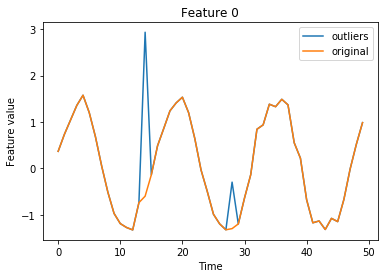

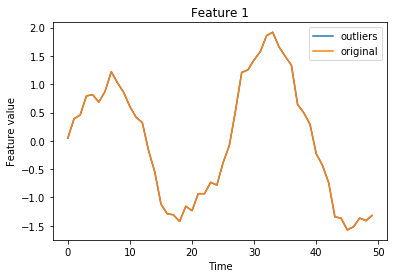

In [8]:
istart, istop = 0, 50
for f in range(n_features):
    plt.plot(X_threshold[istart:istop, f], label='outliers')
    plt.plot(X_thr[istart:istop, f], label='original')
    plt.title('Feature {}'.format(f))
    plt.xlabel('Time')
    plt.ylabel('Feature value')
    plt.legend()
    plt.show()

Let's infer the threshold. The ```inject_outlier_ts``` method distributes perturbations evenly across features. As a result, each feature contains about 5% outliers. We can either set the threshold over both features combined or determine a feature-wise threshold. Here we opt for the **feature-wise threshold**. This is for instance useful when different features have different variance or sensitivity to outliers. We also manually decrease the threshold a bit to increase the sensitivity of our detector:

In [9]:
od.infer_threshold(X_threshold, threshold_perc=np.array([95, 95]))
od.threshold -= .15
print('New threshold: {}'.format(od.threshold))

New threshold: [0.14520847 0.28763998]


Let's save the outlier detector with the updated threshold:

In [10]:
save_detector(od, filepath)

We can load the same detector via `load_detector`:

In [11]:
od = load_detector(filepath)

## Detect outliers

Generate the outliers to detect:

In [12]:
np.random.seed(1)

X_out = X_outlier.copy()
data = inject_outlier_ts(X_outlier, perc_outlier=10, perc_window=10, n_std=2., min_std=1.)
X_outlier, y_outlier, labels = data.data, data.target.astype(int), data.target_names
print(X_outlier.shape, y_outlier.shape)

(100000, 2) (100000,)


Predict outliers:

In [13]:
od_preds = od.predict(X_outlier,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

## Display results

F1 score, accuracy, recall and confusion matrix:

F1 score: 0.928 -- Accuracy: 0.986 -- Recall: 0.896


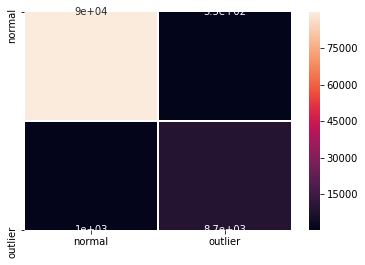

In [18]:
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
acc = accuracy_score(y_outlier, y_pred)
rec = recall_score(y_outlier, y_pred)
print('F1 score: {:.3f} -- Accuracy: {:.3f} -- Recall: {:.3f}'.format(f1, acc, rec))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot the feature-wise outlier scores of the time series for each timestep vs. the outlier threshold:

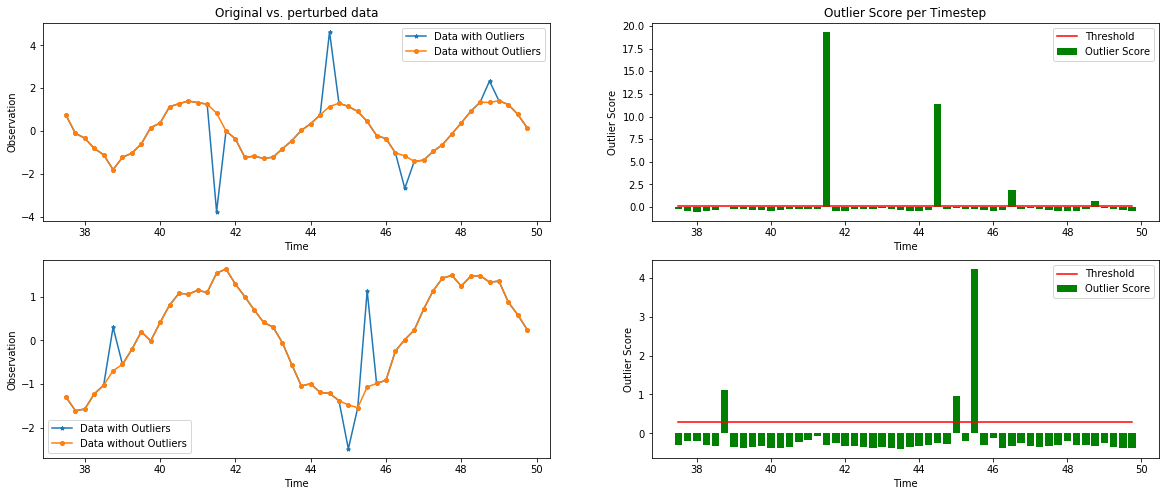

In [19]:
plot_feature_outlier_ts(od_preds,
                        X_outlier, 
                        od.threshold,
                        window=(150, 200),
                        t=time_samples,
                        X_orig=X_out)